In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./pb1data_XW_8358.txt', header=None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,53,40,119,95,66,4,56,101,52,...,13,86,136,9,70,83,60,53,17,88
1,0,42,100,31,126,79,135,84,22,69,...,13,68,35,41,121,51,122,38,36,78
2,0,60,10,16,115,73,124,1,25,62,...,19,77,25,82,18,116,82,76,61,28
3,0,125,76,87,48,101,48,74,11,51,...,121,108,25,97,30,32,131,34,50,125
4,0,24,48,136,84,141,79,82,28,89,...,88,69,141,129,48,37,67,81,108,122


In [4]:
y = data.iloc[:, 0]
x = data.iloc[:, 1:]

#### Preprocessing

In [5]:
x = x.values.astype("float32") / 255.0

In [6]:
mean = np.mean(x)
std = np.std(x)

x = (x - mean) / std

In [7]:
x.shape

(8358, 784)

In [8]:
def evaluate(true_labels: np.ndarray, pred_labels: np.ndarray) -> tuple:
  """Entropy-based evaluation of a label assignment.
 
  Parameters:
    true_labels: the ground-truth class labels on the input data.
    pred_labels: the predicted class labels on the input data.
 
  Returns:
    a tuple (CM, (cs_e, cr_e, we)) containing the confusion matrix `CM`, the class entropies `cs_e`,
    the cluster entropies `cr_e`, and the averaged weighted entropies `we`.
  """
  from scipy.stats import entropy
 
  assert len(true_labels) == len(pred_labels), "Label predictions don't match"
 
  ## Map the labels to index set {0, 1, ..., k - 1 }
  t_classes, t_labels = np.unique(true_labels, return_inverse=True)
  p_classes, p_labels = np.unique(pred_labels, return_inverse=True)
  assert np.all(np.isin(p_classes, t_classes)), "Predicted class outside of labels given"
 
  ## Accumulate the counts
  n_classes = len(t_classes)
  CM = np.zeros(shape=(n_classes, n_classes), dtype=np.uint32)
  ind = np.ravel_multi_index([t_labels, p_labels], CM.shape)
  np.add.at(CM.ravel(), ind, 1)
 
  ## Compute the entropy of the empirical row/column distributions
  empirical_dist = lambda x: x / np.sum(x)
  cluster_entropy = np.apply_along_axis(lambda x: entropy(empirical_dist(x), base=2), 0, CM)
  class_entropy = np.apply_along_axis(lambda x: entropy(empirical_dist(x), base=2), 1, CM)
 
  ## Average w/ count weights
  w_cluster_entropy = np.sum(cluster_entropy * CM.sum(axis=0)) / len(y)
  w_class_entropy = np.sum(class_entropy * CM.sum(axis=1)) / len(y)
  w_entropies = np.array([w_class_entropy, w_cluster_entropy])
 
  with np.printoptions(precision=3):
    print(f"Class Entropies: {class_entropy}")
    print(f"Cluster Entropies: {cluster_entropy}")
    print(f"Weighted average entropies: {w_entropies}, (avg: {np.mean(w_entropies):.3f})")
  return CM, (w_class_entropy, w_cluster_entropy, w_entropies)

### 1. KMeans 

In [9]:
model1 = KMeans(n_clusters=10, max_iter=400, tol=1e-5, random_state=42)

model1.fit(x)

y_pred = model1.predict(x)

In [10]:
counts, entropies = evaluate(y, y_pred)

Class Entropies: [1.377 1.093 2.443 1.753 2.062 2.177 1.565 1.584 2.634 1.744]
Cluster Entropies: [1.897 2.035 1.118 2.179 1.946 1.156 0.984 2.155 0.573 2.241]
Weighted average entropies: [1.76  1.685], (avg: 1.722)


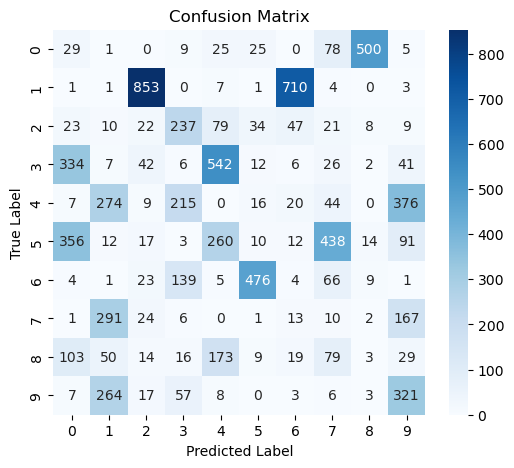

In [11]:
plt.figure(figsize=(6, 5))
sns.heatmap(counts, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### 2. PCA + KMeans

##### 50 dim

In [12]:
PCA1 = PCA(n_components=50)
x_50 = PCA1.fit_transform(x)

In [13]:
x_50.shape

(8358, 50)

In [ ]:
model2 = KMeans(n_clusters=10, max_iter=400, tol=1e-5, random_state=42)

y_pred_50 = model2.fit_predict(x_50)

In [15]:
counts_50, entropies_50 = evaluate(y, y_pred_50)

Class Entropies: [1.757 1.074 2.222 1.731 1.915 2.449 1.469 1.621 2.497 1.731]
Cluster Entropies: [1.751 1.174 0.787 2.324 1.176 2.014 2.041 1.71  1.004 2.438]
Weighted average entropies: [1.779 1.767], (avg: 1.773)


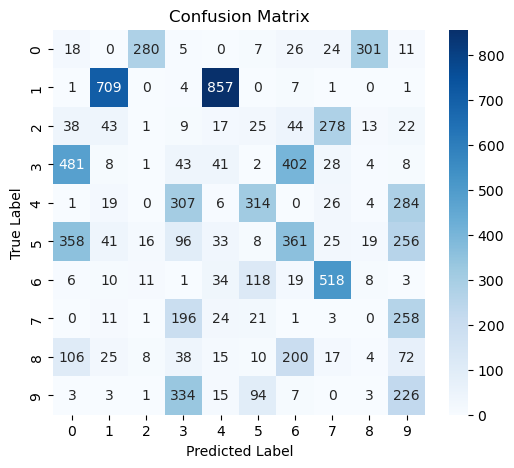

In [16]:
plt.figure(figsize=(6, 5))
sns.heatmap(counts_50, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

##### 200 dim

In [18]:
PCA2 = PCA(n_components=200)
x_200 = PCA2.fit_transform(x)

In [19]:
x_200.shape

(8358, 200)

In [20]:
model3 = KMeans(n_clusters=10, max_iter=400, tol=1e-5, random_state=42)

y_pred_200 = model3.fit_predict(x_200)

In [21]:
counts_200, entropies_200 = evaluate(y, y_pred_200)

Class Entropies: [1.392 1.11  2.5   2.016 1.719 2.334 1.339 1.473 2.355 1.515]
Cluster Entropies: [1.865 0.871 2.517 1.986 1.044 1.921 1.606 1.65  0.562 1.905]
Weighted average entropies: [1.722 1.634], (avg: 1.678)


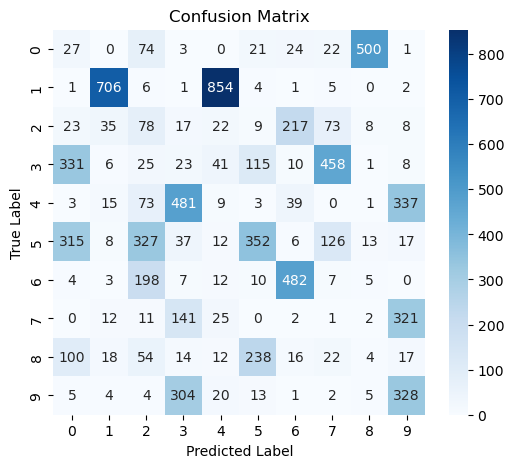

In [22]:
plt.figure(figsize=(6, 5))
sns.heatmap(counts_200, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### 3. PCA(d=200) + DBSCAN

In [23]:
from sklearn.cluster import DBSCAN

In [24]:
# find a suitable epsilon

from sklearn.neighbors import NearestNeighbors

def plot_k_distances(X, k, metric = 'Euclidean'):
    if metric == 'Euclidean':
        nn = NearestNeighbors(n_neighbors=k)
    else:
        nn = NearestNeighbors(n_neighbors=k, metric=metric)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    distances = np.sort(distances[:, -1])

    plt.plot(distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}-th Nearest Neibor Distance")
    plt.title("K-Distance Graph")
    plt.show()

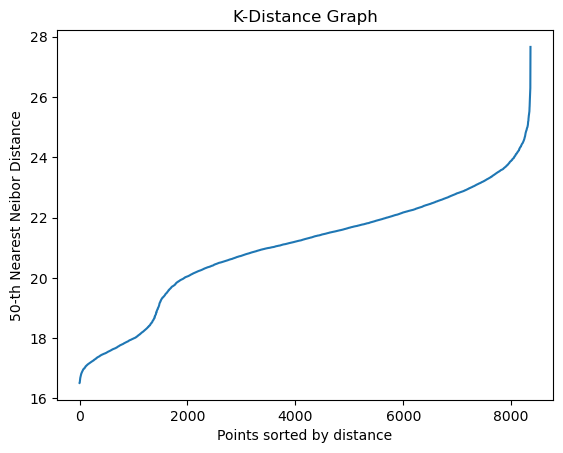

In [25]:
plot_k_distances(x_200, k=50)

In [26]:
# develop confusion matrix

def matrix_develop(y, labels, num=12):
    matrix = np.array([[0] * num for _ in range(num)])
    for i in range(len(labels)):
        pred = int(labels[i]) + 2
        real = int(y[i]) + 2
        matrix[real, pred] += 1

    return matrix

In [27]:
import matplotlib.pyplot as plt

def plot_heatmap(matrix, title):

    num_labels = matrix.shape[0]
    x_labels = list(range(-2, num_labels-2))
    y_labels = list(range(-2, num_labels-2))


    fig, ax = plt.subplots()
    im = ax.imshow(matrix)

    # show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(x_labels)), labels=x_labels)
    ax.set_yticks(range(len(y_labels)), labels=y_labels)

    # loop over data dimensions and create text annotations
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="w")

    ax.set_xlabel('Cluster_ID')
    ax.set_ylabel('True Class')
    ax.set_title(title)
    fig.tight_layout()
    plt.show()
    

In [58]:
model4 = DBSCAN(eps=20, min_samples=50)
result4 = model4.fit(x_200)

In [59]:
np.unique(result4.labels_)

array([-1,  0], dtype=int64)

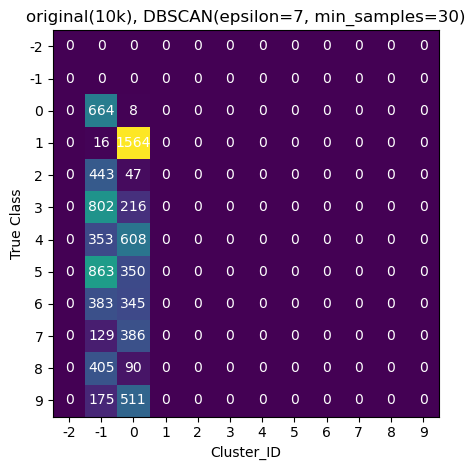

In [ ]:
matrix4 = matrix_develop(y, result4.labels_, 12)
plot_heatmap(matrix4, 'original(10k), DBSCAN(epsilon=20, min_samples=50)')

### 5. PCA(d=200) + Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

model5 = SpectralClustering(n_clusters=10, random_state=42)

y_pred_sc = model5.fit_predict(x_200)


In [ ]:
counts_sc, entropies_sc = evaluate(y, y_pred_sc)

Class Entropies: [0.263 0.381 0.333 0.31  0.346 0.303 0.347 0.372 0.327 0.284]
Cluster Entropies: [3.212 2.986 3.101 0.    2.126 1.792 2.128 3.172 3.056 3.133]
Weighted average entropies: [0.33  3.205], (avg: 1.767)


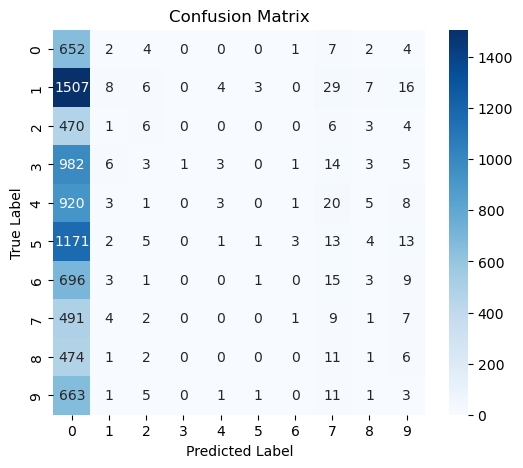

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(counts_sc, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 6. Autoencoder

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

In [38]:
input_dim = x.shape[1]
encoding_dim = 32  # 

# encoder
input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# decoder
decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder
autoencoder = keras.Model(inputs=input_layer, outputs=decoded)

encoder = keras.Model(inputs=input_layer, outputs=encoded)

# compile
autoencoder.compile(optimizer='adam', loss='mse')


In [39]:
history = autoencoder.fit(
    x, x,
    epochs=50,
    batch_size=256,
    shuffle=True
)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1185
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8882
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8522
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8298
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8131
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8005
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7943
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7875
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7826
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7796
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7759
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7736
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7704
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7676
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7659
Epoch 16/50
33/33 ━

In [41]:
x_encoded = encoder.predict(x)


262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [42]:
from sklearn.cluster import KMeans

n_clusters = 10

# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

y_pred_auto = kmeans.fit_predict(x_encoded)

In [43]:
counts_auto, entropies_auto = evaluate(y, y_pred_auto)

Class Entropies: [1.987 1.353 2.253 2.074 1.979 2.435 1.689 1.822 2.707 2.001]
Cluster Entropies: [2.076 2.958 0.83  2.325 0.462 1.686 2.015 2.967 0.637 1.952]
Weighted average entropies: [1.965 1.911], (avg: 1.938)


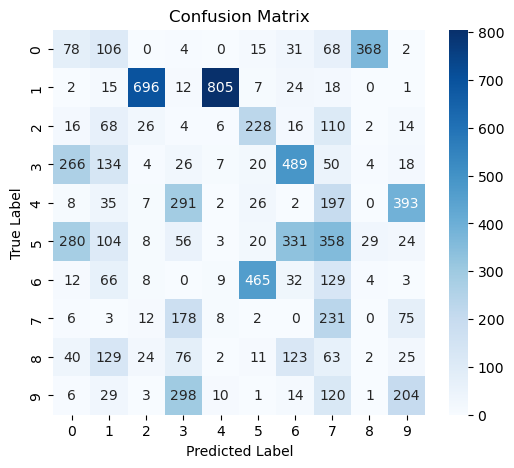

In [44]:
plt.figure(figsize=(6, 5))
sns.heatmap(counts_auto, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 7. PCA(d=200) + TSNE + KMeans

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

In [46]:
# dim = 2

tsne = TSNE(n_components=2, perplexity=40, metric='euclidean', random_state=42)

x_tsne = tsne.fit_transform(x_200)

kmeans = KMeans(n_clusters=10, random_state=42)

y_pred_tsne = kmeans.fit_predict(x_tsne)

In [48]:
counts_tsne, entropies_tsne = evaluate(y, y_pred_tsne)

Class Entropies: [0.248 1.078 1.989 1.207 1.271 1.507 0.324 0.958 2.274 1.41 ]
Cluster Entropies: [0.338 1.744 1.798 0.539 1.03  1.368 0.737 0.69  1.383 1.272]
Weighted average entropies: [1.19  1.105], (avg: 1.147)


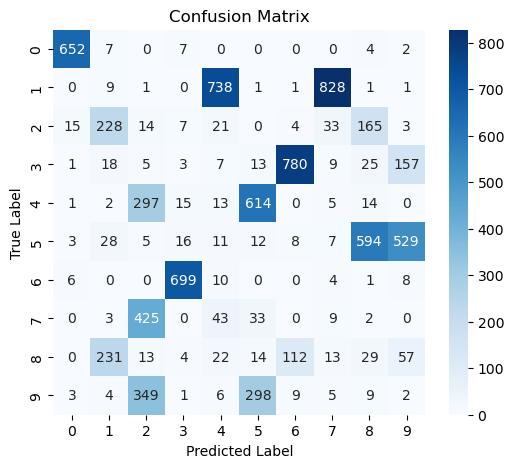

In [49]:
plt.figure(figsize=(6, 5))
sns.heatmap(counts_tsne, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 8. UMAP + KMeans

In [50]:
import umap

model8 = umap.UMAP(n_components=32, random_state=42)  # 32 dim

x_umap = model8.fit_transform(x)


c:\Users\Churou\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [51]:
kmeans = KMeans(n_clusters=10, random_state=42)

y_pred_umap = kmeans.fit_predict(x_umap)


Class Entropies: [0.247 1.054 1.307 0.488 1.331 1.394 0.379 0.978 2.02  1.707]
Cluster Entropies: [1.568 1.093 1.002 0.397 0.919 1.341 0.405 1.101 0.573 1.339]
Weighted average entropies: [1.063 1.057], (avg: 1.060)


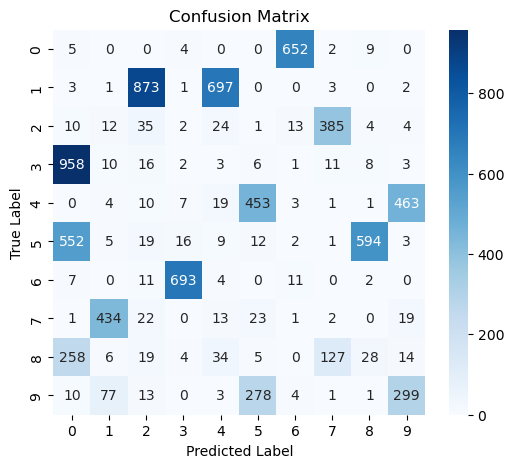

In [52]:
counts_umap, entropies_umap = evaluate(y, y_pred_umap)

plt.figure(figsize=(6, 5))
sns.heatmap(counts_umap, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 9. CNN + KMeans

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [54]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x  # feature maps



In [55]:
model = SimpleCNN()
model.eval()  # extract features

# turn x into torch.tensor
x_tensor = torch.tensor(x).unsqueeze(1)  # [batch_size, 1, H, W]
x_tensor = x_tensor.float()
x_tensor = x_tensor.view(-1, 1, 28, 28)

with torch.no_grad():
    features = model(x_tensor)  # [batch_size, C, H, W]


features_flat = features.view(features.size(0), -1)  # [batch_size, feature_dim]


In [56]:
kmeans = KMeans(n_clusters=10, random_state=42)

y_pred_cnn = kmeans.fit_predict(features_flat.numpy())

Class Entropies: [1.224 1.092 2.036 1.816 1.544 2.145 1.422 1.324 2.493 1.888]
Cluster Entropies: [1.722 1.199 1.844 1.425 2.245 1.735 1.928 1.185 0.701 1.556]
Weighted average entropies: [1.642 1.58 ], (avg: 1.611)


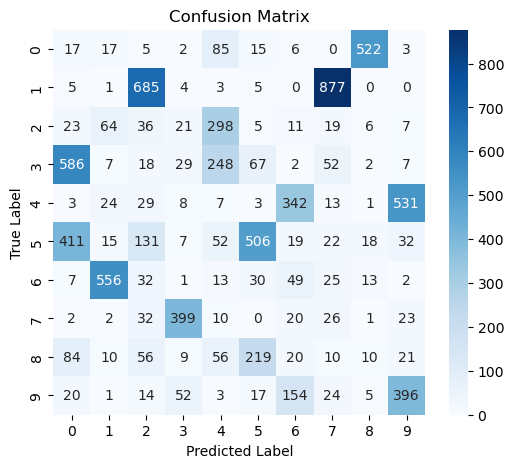

In [57]:
counts_cnn, entropies_cnn = evaluate(y.values, y_pred_cnn)

plt.figure(figsize=(6, 5))
sns.heatmap(counts_cnn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()